<a href="https://colab.research.google.com/github/aminekhasteh/DeepLearningFinalReport2020/blob/master/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import numpy as np
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
main_dir = '/content/drive/My Drive/Colab Notebooks/Breast Cancer'

In [19]:
csv_stage = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Breast Cancer/brca-clinicalforwiki_TCIA.xlsx')

Converting the training data into tensor

In [20]:
training_names = os.listdir(main_dir + '/' + 'Training')
names=training_names[0]
miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
miz = miz.convert("L")
new = np.asarray(miz)
new_normalised = (new-new.mean())/new.std()
training_tensor = np.expand_dims(new_normalised, axis=0)
Y = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
j=1
for names in training_names[1:]:
    Y.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[j][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    j=j+1
    miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = (new-new.mean())/new.std()
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    training_tensor = np.concatenate((training_tensor, new_tensor), axis=0)

In [21]:
training_tensor.shape

(594, 256, 256)

Converting the testing data into tensor:

In [22]:
testing_names = os.listdir(main_dir + '/' + 'Testing')
names=testing_names[0]
miz1 = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
miz1 = miz.convert("L")
new1 = np.asarray(miz1)
new_normalised1 = (new-new.mean())/new.std()
testing_tensor = np.expand_dims(new_normalised1, axis=0)
Y_test = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
k = 1
for names in testing_names[1:]:
    Y_test.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[k][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    k=k+1
    miz = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = (new-new.mean())/new.std()
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    testing_tensor = np.concatenate((testing_tensor, new_tensor), axis=0)

In [23]:
testing_tensor.shape

(152, 256, 256)

Expanding the dataset one more time, we do this so the format of our data is right for training.

In [24]:
training_tensor = np.expand_dims(training_tensor, axis=3)
testing_tensor = np.expand_dims(testing_tensor, axis=3)

Description of our dataset:

In [25]:
print('Training shape:', training_tensor.shape)
print(training_tensor.shape[0], 'sample,',training_tensor.shape[1] ,'x',training_tensor.shape[2] ,'size grayscale image.\n')
print('Test shape:', testing_tensor.shape)
print(testing_tensor.shape[0], 'sample,',testing_tensor.shape[1] ,'x',testing_tensor.shape[2] ,'size grayscale image.\n')

Training shape: (594, 256, 256, 1)
594 sample, 256 x 256 size grayscale image.

Test shape: (152, 256, 256, 1)
152 sample, 256 x 256 size grayscale image.



Looking at the normalized transformed to tensor images

Examples:


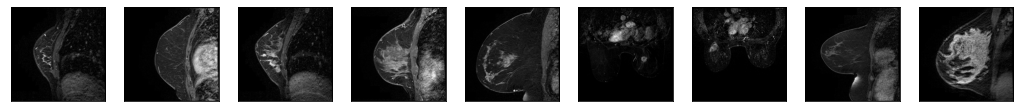

In [26]:
print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(training_tensor[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Since our inputs are images, we used convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders because they perform better. Our encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder consists in a stack of Conv2D and UpSampling2D layers. 

In [27]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
input_img = Input(shape=(256, 256, 1))  # adapt this if using `channels_first` image data format
num_classes = 7

In [28]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [29]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [30]:
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 64)     

Now we train the data. First, we open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

In [31]:
autoencoder_train = autoencoder.fit(training_tensor, training_tensor, 
                                    batch_size=64,
                                    epochs=200,
                                    validation_data=(testing_tensor, testing_tensor), 
                                    shuffle=True)

Epoch 1/200
10/10 [==============================] - 6s 574ms/step - loss: 1.0408 - val_loss: 1.5722
Epoch 2/200
10/10 [==============================] - 4s 400ms/step - loss: 0.6555 - val_loss: 1.4164
Epoch 3/200
10/10 [==============================] - 4s 399ms/step - loss: 0.6312 - val_loss: 1.1365
Epoch 4/200
10/10 [==============================] - 4s 401ms/step - loss: 0.6214 - val_loss: 0.9948
Epoch 5/200
10/10 [==============================] - 4s 402ms/step - loss: 0.6170 - val_loss: 0.8591
Epoch 6/200
10/10 [==============================] - 4s 400ms/step - loss: 0.6028 - val_loss: 0.8090
Epoch 7/200
10/10 [==============================] - 4s 400ms/step - loss: 0.6050 - val_loss: 0.8533
Epoch 8/200
10/10 [==============================] - 4s 399ms/step - loss: 0.5941 - val_loss: 0.7935
Epoch 9/200
10/10 [==============================] - 4s 400ms/step - loss: 0.5919 - val_loss: 0.8194
Epoch 10/200
10/10 [==============================] - 4s 399ms/step - loss: 0.6798 - val_lo

Plotting the loss function

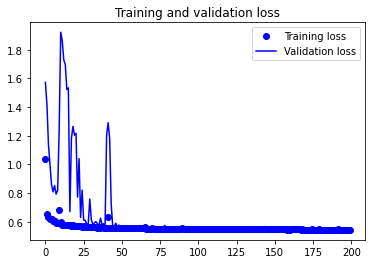

In [32]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Saving the complete autoencoder weights

In [45]:
autoencoder.save_weights('autoencoder.h5')

In [33]:
decoded_imgs = autoencoder.predict(testing_tensor)

Displaying the original against the reconstructed images through encoding and decoding.

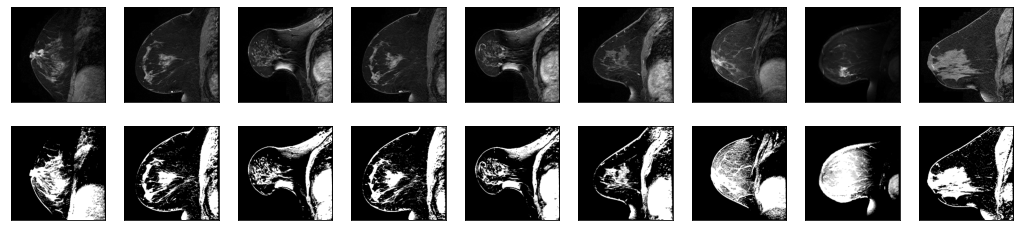

In [34]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(testing_tensor[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Creating dictionary of target classes

In [ ]:
label_dict = {
 1: 'Stage I',
 2: 'Stage IA',
 3: 'Stage II',
 4: 'Stage IIA',
 5: 'Stage IIB',
 6: 'Stage IIIA',
 7: 'Stage IIIB'
}
num_classes = 7

Converting the labels into one-hot encoding vectors:

In [46]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(Y)
test_Y_one_hot = to_categorical(Y_test)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

ValueError: ignored